In [172]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Keeps notebooks clean 
import warnings
warnings.filterwarnings("ignore") 


from datetime import datetime
from collections import namedtuple

In [173]:
!pip install geopandas

In [174]:
import geopandas as gpd

In [175]:
pwd

'/Users/Monika/Projects'

In [176]:
df_collisions = pd.read_csv('data/collisions_orig.csv', parse_dates=["INCDTTM"])
df_locations_xy = pd.read_csv('data/location_xy.csv')

In [177]:
# Check the starting shape
df_collisions.shape

(220436, 40)

In [178]:
# Save column list to restore column order after merge
column_list = df_collisions.columns
column_list = column_list.append(pd.Index(['fe_exists']))

In [179]:
# Drop the old X,Y and replace with the ones in location_xy.csv if they exist, otherwise, will be nan
df_collisions.drop(columns=['X','Y'],inplace=True,errors='ignore')   # get these from the location_xy.csv file
df_collisions.shape

(220436, 38)

In [180]:
df_new = pd.merge(df_collisions, df_locations_xy, on='LOCATION', how='left')

In [181]:
# Do some sanity checks
df_new.shape

(220436, 41)

In [182]:
# Restore the original order of columns
df_new = df_new[column_list]

In [183]:
df_new.drop_duplicates(inplace=True)

In [184]:
df_new['fe_exists'].value_counts()

1    216059
0      4377
Name: fe_exists, dtype: int64

In [185]:
new_keys = list(df_new['INCKEY'])
col_keys = list(df_collisions['INCKEY'])
print(f"{len(new_keys)}   {len(col_keys)}")

220436   220436


In [186]:
#Dropping columns deemed unnecessary
df_new.drop(['EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'STATUS', 'REPORTNO', 'SEGLANEKEY', 'CROSSWALKKEY', 'INCKEY','COLDETKEY'],axis=1, inplace=True)

In [187]:
#to lowercase
df_new.columns = df_new.columns.str.lower()

In [188]:
df_new.columns

Index(['x', 'y', 'objectid', 'addrtype', 'intkey', 'location', 'severitycode',
       'severitydesc', 'collisiontype', 'personcount', 'pedcount',
       'pedcylcount', 'vehcount', 'injuries', 'seriousinjuries', 'fatalities',
       'incdate', 'incdttm', 'junctiontype', 'sdot_colcode', 'sdot_coldesc',
       'inattentionind', 'underinfl', 'weather', 'roadcond', 'lightcond',
       'pedrownotgrnt', 'sdotcolnum', 'speeding', 'st_colcode', 'st_coldesc',
       'hitparkedcar', 'fe_exists'],
      dtype='object')

In [189]:
print(df_new['x'].isnull().sum())
print(df_new['y'].isnull().sum())

7189
7189


In [190]:
#FE time, total_injuries and total_person_count columns
df_new["time"]=df_new['incdttm'].dt.strftime('%H:%M')
df_new["total_injuries"]=df_new['injuries'] + df_new['seriousinjuries']  + df_new['fatalities']
df_new["total_person_count"]=df_new['personcount'] + df_new['pedcount']  + df_new['pedcylcount']

In [191]:
#FE emd column for the missing 26,000
fe_emd_crit = (df_new['weather'].isnull() &
    df_new['lightcond'].isnull() &
    df_new['roadcond'].isnull() &
    df_new['collisiontype'].isnull() &
    df_new['st_coldesc'].isnull() &
    df_new['underinfl'].isnull() &
    df_new['inattentionind'].isnull() &
    df_new['speeding'].isnull() &
    df_new['pedrownotgrnt'].isnull() &
    (df_new['vehcount'] == 0))
df_new['fe_emd'] = fe_emd_crit

In [192]:
#converting incdate to datetime
df_new["incdate"] = df_new["incdate"].astype("datetime64")

In [193]:
#Rebecca's contribution: filling in missing values
categories = ["addrtype", "collisiontype", "severitydesc", "lightcond",
             "speeding", "junctiontype", "roadcond", "weather"]

for col in categories:
    df_new[col] = df_new[col].replace({np.nan: "Unknown", "Other": "Unknown"})
    
df_new["pedrownotgrnt"] = df_new["pedrownotgrnt"].replace({np.nan: "N"})    

# While we are at it, let's go ahead and clean up missing values for these two:
df_new["st_coldesc"] = df_new["st_coldesc"].replace({np.nan: "Unknown"})  
df_new["sdot_coldesc"] = df_new["sdot_coldesc"].replace({np.nan: "Unknown"})

df_new["underinfl"] = df_new["underinfl"].replace({"0": "N", "1": "Y", np.nan: "X"})

In [194]:
#df2 = df_new.set_index('incdate') #change index to incdate 
#df2['2004-01-02'] 

In [195]:
#df2.loc['2004-01-02']['weather'].value_counts()

In [196]:
#Jeny - work in progress
#for each column, get value counts in decreasing order and take the index (value) of most common class
#weather_imputed = df2.apply(lambda x: x.fillna(x.value_counts().ind))
#df_most_common_imputed = colors.apply(lambda x: x.fillna(x.value_counts().index[0]))
#df_most_common_imputed

#df2['weather'] = df2['weather'].apply(lambda x: x.fillna(x.value_counts().index[0]))

In [198]:
df_new.columns

Index(['x', 'y', 'objectid', 'addrtype', 'intkey', 'location', 'severitycode',
       'severitydesc', 'collisiontype', 'personcount', 'pedcount',
       'pedcylcount', 'vehcount', 'injuries', 'seriousinjuries', 'fatalities',
       'incdate', 'incdttm', 'junctiontype', 'sdot_colcode', 'sdot_coldesc',
       'inattentionind', 'underinfl', 'weather', 'roadcond', 'lightcond',
       'pedrownotgrnt', 'sdotcolnum', 'speeding', 'st_colcode', 'st_coldesc',
       'hitparkedcar', 'fe_exists', 'time', 'total_injuries',
       'total_person_count', 'fe_emd', 'hourandmin', 'hour', 'min'],
      dtype='object')

In [199]:
#Monika's contribution datetime conversion
df_new['hourandmin'] = pd.to_datetime(df_new['time'], format ='%H:%M')
df_new['hour'] = df_new['hourandmin'].dt.hour
df_new['min'] = df_new['hourandmin'].dt.minute
#df_new.drop(df_new['hourandmin'],axis=1,inplace=True)

In [201]:
#seeing what percentage have 00:00 as the hour and minute
len(df_new[(df_new['hour']==0) & (df_new['min']==0)])/len(df_new)

0.2368215717940808

In [202]:
fe_emd_time = ((df_new['hour']==0) &
    (df_new['min']==0))
df_new['fe_tmd'] = fe_emd_time

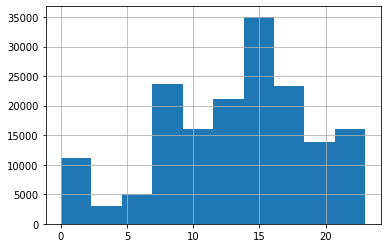

In [203]:
df_new['hour'][df_new['fe_tmd']==False].hist()

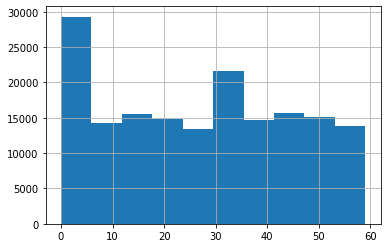

In [204]:
df_new['min'][df_new['fe_tmd']==False].hist()

In [205]:
#This is the Ride the Ducks fatal crash from 2015. Removing outlier.
df_new = df_new[df_new['total_person_count']!=93]

In [206]:
#Niwako's contribution for collision codes
labels = list(df_new['st_coldesc'].unique())
labels

['Vehicle backing hits pedestrian',
 'Unknown',
 'Entering at angle',
 'From same direction - both going straight - both moving - sideswipe',
 'From same direction - all others',
 'One car entering driveway access',
 'From opposite direction - one left turn - one straight',
 'From same direction - both going straight - one stopped - rear-end',
 'Fixed object',
 'From same direction - both going straight - both moving - rear-end',
 'One parked--one moving',
 'Same direction -- both turning right -- both moving -- sideswipe',
 'Pedalcyclist Strikes Moving Vehicle',
 'Breakage of any part of the vehicle resulting in injury or in further property damage',
 'One car leaving parked position',
 'From opposite direction - both going straight - one stopped - sideswipe',
 'From same direction - both going straight - one stopped - sideswipe',
 'Same direction -- both turning right -- one stopped -- rear end',
 'Same direction -- both turning left -- both moving -- sideswipe',
 'From same directio

In [207]:
vehicle_only_labels = [
    label 
    for label in df_new['st_coldesc'].dropna().unique() 
    if label.startswith('From same direction')
    or label.startswith('From opposite direction')
    or label.startswith('One car')
    or label.startswith('One parked')
    or label.startswith('Vehicle overturned')
    or label.startswith('All Other Multi Vehicle')
    
]
vehicle_only_labels

['From same direction - both going straight - both moving - sideswipe',
 'From same direction - all others',
 'One car entering driveway access',
 'From opposite direction - one left turn - one straight',
 'From same direction - both going straight - one stopped - rear-end',
 'From same direction - both going straight - both moving - rear-end',
 'One parked--one moving',
 'One car leaving parked position',
 'From opposite direction - both going straight - one stopped - sideswipe',
 'From same direction - both going straight - one stopped - sideswipe',
 'From same direction - one right turn - one straight',
 'From opposite direction - one stopped - head-on',
 'Vehicle overturned',
 'From opposite direction - all others',
 'From same direction - one left turn - one straight',
 'From opposite direction - both going straight - sideswipe',
 'From opposite direction - both moving - head-on',
 'One car entering parked position',
 'One car leaving driveway access',
 'From opposite direction - 

In [208]:
vehicle_only_df = df_new[df_new['st_coldesc'].isin(vehicle_only_labels)]
vehicle_only_df.shape

(127568, 41)

In [209]:
vehicle_only_df.head()

,x,y,objectid,addrtype,intkey,location,severitycode,severitydesc,collisiontype,personcount,...,hitparkedcar,fe_exists,time,total_injuries,total_person_count,fe_emd,hourandmin,hour,min,fe_tmd
3,-122.320383,47.539432,4,Intersection,34194.0,ELLIS AVE S AND S MYRTLE ST,1,Property Damage Only Collision,Sideswipe,2,...,N,1,08:12,0,2,False,1900-01-01 08:12:00,8,12,False
6,-122.346793,47.662069,7,Block,NaN,N 46TH ST BETWEEN PHINNEY TURN RD AND GREEN LA...,1,Property Damage Only Collision,Unknown,2,...,N,1,08:48,0,2,False,1900-01-01 08:48:00,8,48,False
8,-122.318085,47.550433,9,Block,NaN,AIRPORT WAY S BETWEEN S HOMER ST AND S DORIS ST,1,Property Damage Only Collision,Unknown,2,...,N,1,10:34,0,2,False,1900-01-01 10:34:00,10,34,False
9,-122.330444,47.624275,10,Intersection,29121.0,MERCER ST AND YALE AVE N,1,Property Damage Only Collision,Left Turn,4,...,N,1,00:00,0,4,False,1900-01-01 00:00:00,0,0,True
10,-122.351134,47.570942,11,Block,NaN,WEST SEATTLE BR EB BETWEEN ALASKAN WY VI NB ON...,1,Property Damage Only Collision,Rear Ended,2,...,N,0,08:28,0,2,False,1900-01-01 08:28:00,8,28,False


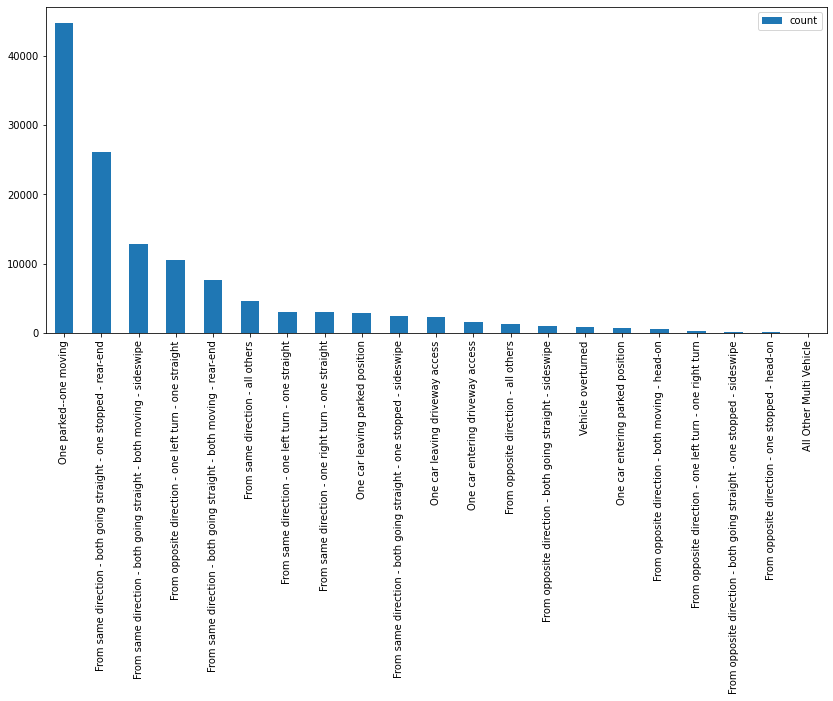

In [210]:
vehicle_only_df['st_coldesc'].value_counts().to_frame('count').plot.bar(figsize=(14, 6))

## Merge with GEOJSON
Using geopandas to join our collisions dataset to the Census file using our x/y coordinates.


In [211]:
# Create a dataframe that includes a new feature called geometry, which is basically a point made from x & y           
gdf_collisions = gpd.GeoDataFrame(df_new, geometry=gpd.points_from_xy(df_new.x, df_new.y))
# This will show the newly created geometry geo feature
gdf_collisions.head(1)

,x,y,objectid,addrtype,intkey,location,severitycode,severitydesc,collisiontype,personcount,...,fe_exists,time,total_injuries,total_person_count,fe_emd,hourandmin,hour,min,fe_tmd,geometry
0,-122.340472,47.608629,1,Intersection,29598.0,PIKE PL AND PIKE ST,2,Injury Collision,Pedestrian,2,...,1,18:36,1,3,False,1900-01-01 18:36:00,18,36,False,POINT (-122.34047 47.60863)


In [212]:
# Open the Census Tracts Geo file
geojson_file = "data/Census_Tracts_2010.geojson"
census_tracts = gpd.read_file(geojson_file)
census_tracts.head(1)

,OBJECTID,TRACT,TRACTCE10,GEOID10,NAME10,NAMELSAD10,ACRES_TOTAL,WATER,SHAPE_Length,SHAPE_Area,geometry
0,1,2500,002500,53033002500,25,Census Tract 25,243.219083,0,16442.968402,1.059462e+07,"POLYGON ((-122.29602 47.69023, -122.29608 47.6..."


In [213]:
# conda install rtree

In [214]:
# Join the two - a left join means we wont loose records from our collision dataset. within means the x/y pont must be contained within the census polygon
df_with_geo = gpd.sjoin(gdf_collisions, census_tracts, how="left", op="within")

In [215]:
# Make sure it was a left join and we didn't loose any records
print("Original df shape:", df_new.shape)
print("New df shape:", df_with_geo.shape)

Original df shape: (220435, 42)
New df shape: (220435, 53)


In [216]:
# Drop un-needed columns
df_with_geo.drop(['OBJECTID', 'TRACT', 'TRACTCE10', 'GEOID10', 'NAME10', 'WATER', 'geometry', 'SHAPE_Area', 'SHAPE_Length', 'ACRES_TOTAL', 'index_right', 'SHAPE_Length', 'SHAPE_Area'],axis=1, inplace=True)
df_with_geo.head(1)

,x,y,objectid,addrtype,intkey,location,severitycode,severitydesc,collisiontype,personcount,...,fe_exists,time,total_injuries,total_person_count,fe_emd,hourandmin,hour,min,fe_tmd,NAMELSAD10
0,-122.340472,47.608629,1,Intersection,29598.0,PIKE PL AND PIKE ST,2,Injury Collision,Pedestrian,2,...,1,18:36,1,3,False,1900-01-01 18:36:00,18,36,False,Census Tract 81


In [217]:
df_with_geo.columns = df_with_geo.columns.str.lower()

## Merge with Neighborhood Csv
Mergin with this dataset (created using Tableau) which contains the neighborhood for each census group

In [218]:
# Now we can pull neighborhood from the csv I created from tableau

df_neighborhood = pd.read_csv('data/location_neighborhood_census_area.csv')
df_neighborhood.shape

(135, 2)

In [219]:
df_with_geo_neighborhood = pd.merge(df_with_geo, df_neighborhood, on='namelsad10', how='left')

In [220]:
df_with_geo_neighborhood.head(1)

,x,y,objectid,addrtype,intkey,location,severitycode,severitydesc,collisiontype,personcount,...,time,total_injuries,total_person_count,fe_emd,hourandmin,hour,min,fe_tmd,namelsad10,neighborhood
0,-122.340472,47.608629,1,Intersection,29598.0,PIKE PL AND PIKE ST,2,Injury Collision,Pedestrian,2,...,18:36,1,3,False,1900-01-01 18:36:00,18,36,False,Census Tract 81,Downtown / Waterfront


In [221]:
# Rename census area column to something that makes more sense
df_with_geo_neighborhood=df_with_geo_neighborhood.rename(columns = {'namelsad10':'census_area'})

In [222]:
# Make sure it was a left join and we didn't loose any records
print("Original df shape:", df_new.shape)
print("New df shape:", df_with_geo_neighborhood.shape)

Original df shape: (220435, 42)
New df shape: (220435, 43)


In [223]:
# rename dataframe back to what we were using before
df_new=df_with_geo_neighborhood

## Impute missing weather with date and census area
If that doesn't work, then we will try neighborhood

In [224]:
# Define a Named Tuple Here so that we can use it in the rest of the notebook

DateArea = namedtuple("DateArea", ["date", "area"])

def make_date_area_env_dict(df, date, area, env_condition):
    # Creating a dictionary that has a named tuple as the key, basically (date,area) and a dict of environmental (like weather) conditions conditions as the value
    # My intent is to count the number of environmental (like weather) conditions for the date/area combination so that the one with the highst count wins

    #Only use those records with values for all three features, date, area and environmental (like weather) conditions
    df_with_values = df[df["incdate"].notnull() & df[area].notnull() & df[env_condition].notnull()  ]
    
    # Overall Dictionary Object to track all this informaiton
    loc_date_dict = dict()
    for idx, row in df_with_values.iterrows():
        # This is my date/area tuple
        dl = DateArea(date=str(row[date]), area=row[area])
        if dl in loc_date_dict.keys():
            env_dict = loc_date_dict[dl]
            if row[env_condition] in env_dict.keys():
                env_dict[row[env_condition]] +=1
            else:
                env_dict[row[env_condition]]=1
                loc_date_dict[dl]=env_dict
        else:
            env_dict = dict()
            env_dict[row[env_condition]]  = 1
            loc_date_dict[dl]= env_dict
    return loc_date_dict

In [225]:
# Create Dictionary using date, census area for the named tuple (key) and a dictionary of the most common weather conditions for the value
dict_date_census_weather = make_date_area_env_dict(df_new, "incdate", "census_area", "weather")
count_imputed=0

In [226]:
# How many records do we have where weather is null, but date and census area are not
df_no_weather = df_new[df_new["incdate"].notnull() & df_new["census_area"].notnull() & ((df_new[ "weather"]=="Unknown") | (df_new[ "weather"].isnull())) ]
df_no_weather.shape

(38560, 43)

In [227]:
# Take a look at the first 15 items of our imputing dictionary
first_5=0
for key, value in dict_date_census_weather.items() :
    if first_5<5: print(key)
    if first_5<5: print(value)    
    first_5+=1

DateArea(date='2004-10-14 00:00:00', area='Census Tract 81')
{'Overcast': 1, 'Unknown': 2, 'Clear': 1}
DateArea(date='2020-01-22 00:00:00', area='Census Tract 119')
{'Unknown': 1}
DateArea(date='2020-01-05 00:00:00', area='Census Tract 12')
{'Raining': 1}
DateArea(date='2020-02-13 00:00:00', area='Census Tract 109')
{'Overcast': 1, 'Clear': 1}
DateArea(date='2020-02-08 00:00:00', area='Census Tract 47')
{'Unknown': 1}


In [228]:
#imputing missing data by neighborhood
dict_date_neighborhood_weather = make_date_area_env_dict(df_new, "incdate", "neighborhood", "weather")

In [229]:
# Take a look at the first 15 items of our imputing dictionary
first_5=0
for key, value in dict_date_neighborhood_weather.items() :
    if first_5<5: print(key)
    if first_5<5: print(value)    
    first_5+=1

DateArea(date='2004-10-14 00:00:00', area='Downtown / Waterfront')
{'Overcast': 1, 'Unknown': 4, 'Clear': 3}
DateArea(date='2020-01-22 00:00:00', area='Rainier Beach / Dunlap')
{'Unknown': 1}
DateArea(date='2020-01-05 00:00:00', area='Northgate')
{'Raining': 1}
DateArea(date='2020-02-13 00:00:00', area='Georgetown')
{'Overcast': 1, 'Clear': 1}
DateArea(date='2020-02-08 00:00:00', area='Ballard')
{'Unknown': 2}


In [230]:
# This function will be used in our lambda expression below. It will try to fill weather with the most common weather condition for the date/census area combo

def find_env_val(dict_env,area_string, date_string, old_val, debug=False):
    dl = DateArea(date=str(date_string), area=area_string)
    if (str(old_val)=="nan" or str(old_val)=="Unknown") and dl in dict_env.keys():  
        env_dict = dict_env[dl]
        # Now we want to find the key of the item in env_dic that has the greatest value (count) and use it to replace our NaN value
        # If they all have equal, then the value selected is kind of random (order that it was added to dictionary)
        new_val = max(env_dict, key=env_dict.get)
        if (debug) and  len(env_dict.keys()) >1: print(f"Filling in env for {area_string}, and {date_string} with {new_val} using this info {env_dict}")
    else:
        new_val = old_val
    #print(f"{area_string}  {newX},{newY}")
    return new_val

In [231]:
df_new['weather'] = df_new.apply(lambda x: find_env_val(dict_date_neighborhood_weather,area_string=x['neighborhood'],date_string=str(x['incdate']), old_val=x['weather'],debug=False), axis=1)

In [232]:
df_no_weather = df_new[df_new["incdate"].notnull() & df_new["census_area"].notnull() & ((df_new[ "weather"]=="Unknown") | (df_new[ "weather"].isnull())) ]
df_no_weather.shape

(24455, 43)

In [233]:
#impute remaining using city
df_new['city']="seattle"

In [234]:
dict_date_city_weather = make_date_area_env_dict(df_new, "incdate", "city", "weather")

In [235]:
df_new['weather'] = df_new.apply(lambda x: find_env_val(dict_date_city_weather,area_string=x['city'],date_string=str(x['incdate']), old_val=x['weather'],debug=False), axis=1)

In [236]:
df_no_weather = df_new[df_new["incdate"].notnull() & df_new["census_area"].notnull() & ((df_new[ "weather"]=="Unknown") | (df_new[ "weather"].isnull())) ]
df_no_weather.shape

(2250, 44)

In [237]:
most_common_value=df_new['weather'].value_counts().index[0]
print(most_common_value)

Clear


In [238]:
df_new['weather'].fillna(most_common_value, inplace=True)
df_new['weather'].replace(['Unknown'], most_common_value, inplace=True)

In [239]:
df_no_weather = df_new[df_new["incdate"].notnull() & df_new["census_area"].notnull() & ((df_new[ "weather"]=="Unknown") | (df_new[ "weather"].isnull())) ]
df_no_weather.shape

(0, 44)

In [241]:
#imputing for road conditions using neighborhoods
dict_date_neighborhood_roadcond = make_date_area_env_dict(df_new, "incdate", "neighborhood", "roadcond")

In [242]:
df_new['roadcond'] = df_new.apply(lambda x: find_env_val(dict_date_neighborhood_weather,area_string=x['neighborhood'],date_string=str(x['incdate']), old_val=x['roadcond'],debug=False), axis=1)
df_no_weather = df_new[df_new["incdate"].notnull() & df_new["census_area"].notnull() & ((df_new[ "roadcond"]=="Unknown") | (df_new[ "roadcond"].isnull())) ]
df_no_weather.shape

(23476, 44)

In [243]:
dict_date_city_roadcond = make_date_area_env_dict(df_new, "incdate", "city", "roadcond")

In [244]:
df_new['roadcond'] = df_new.apply(lambda x: find_env_val(dict_date_city_weather,area_string=x['city'],date_string=str(x['incdate']), old_val=x['roadcond'],debug=False), axis=1)
df_no_weather = df_new[df_new["incdate"].notnull() & df_new["census_area"].notnull() & ((df_new[ "roadcond"]=="Unknown") | (df_new[ "roadcond"].isnull())) ]
df_no_weather.shape

(2207, 44)

In [245]:
most_common_value=df_new['roadcond'].value_counts().index[0]
df_new['roadcond'].fillna(most_common_value, inplace=True)
df_new['roadcond'].replace(['Unknown'], most_common_value, inplace=True)

In [246]:
#exporting to a csv, this will overwrite when more people fill in their nulls
df_new.to_csv('collisions_clean.csv')

In [247]:
df_new.shape

(220435, 44)

# Traffic Flow dataset

In [252]:
# Change this if you have already downloaded from the following URL to a local folder
# https://data-seattlecitygis.opendata.arcgis.com/datasets/2018-traffic-flow-counts

path_to_2018_Traffic_flow = "https://opendata.arcgis.com/datasets/a35aa9249110472ba2c69cc574eff984_11.csv"
#path_to_2018_Traffic_flow = '../z_misc_NO_CHECKIN/2018_Traffic_Flow_Counts.csv'  # Jamie's path

In [254]:
df_flow = pd.read_csv(path_to_2018_Traffic_flow)
df_collisions = pd.read_csv('data/collisions_clean.csv')

In [255]:
print(f"df_flow shape:       {df_flow.shape}")            # Expect 1906, 14
print(f"df_collisions shape: {df_collisions.shape}")      # Expect 220436, 41

df_flow shape:       (1906, 14)
df_collisions shape: (220436, 42)


### Review the columns

In [256]:
df_flow.columns = df_flow.columns.str.lower()
df_flow.columns

Index(['objectid', 'compkey', 'stname_ord', 'flowsegid', 'downtown',
       'start_date', 'ampk', 'pmpk', 'awdt', 'adt', 'awdt_rounded',
       'dataquality', 'flags', 'shape_length'],
      dtype='object')

In [257]:
df_flow.isnull().sum()

objectid           0
compkey           14
stname_ord         0
flowsegid          0
downtown           0
start_date         0
ampk            1001
pmpk            1001
awdt               2
adt              482
awdt_rounded       0
dataquality        0
flags           1882
shape_length       0
dtype: int64

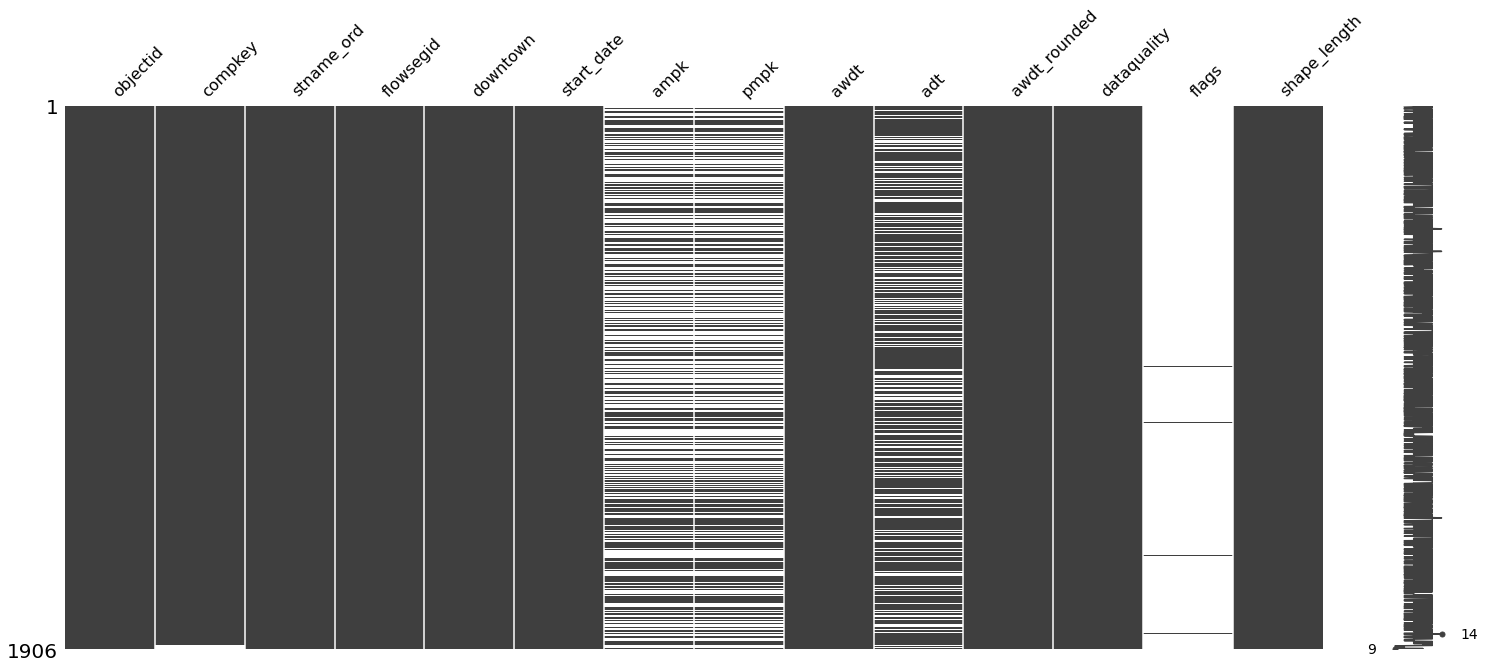

In [259]:
import missingno as msno
msno.matrix(df_flow)

## Issue #1: null compkey values

In [261]:
# How many are there?
df_flow['compkey'].isnull().sum()

14

In [262]:
# What are they?
df_flow[df_flow['compkey'].isnull()].tail(2)
# Ramps - 9
# PL, AVE, ST - 5

,objectid,compkey,stname_ord,flowsegid,downtown,start_date,ampk,pmpk,awdt,adt,awdt_rounded,dataquality,flags,shape_length
1904,1922,NaN,15TH AVE W,1987,N,2018/06/26 00:00:00+00,2356.0,3017.0,36897.0,35258.0,36000,Study(Normalized),NaN,1380.021208
1905,1923,NaN,W SEA BR EB 4 AV OFF RP,2028,N,1970/01/01 00:00:00+00,NaN,NaN,24000.0,NaN,24000,Estimate,NaN,1458.971527


#### Would we have used this data to match to collisions, e.g. based on stname_ord?

In [263]:
list_collision_locs = list(df_collisions['location'].unique())
list_nokey_flow_locs = list(df_flow.loc[df_flow['compkey'].isnull(),'stname_ord'])

In [264]:
print(f"Collision locations: {len(list_collision_locs)}")
print(f"No-key flow locations: {len(list_nokey_flow_locs)}")

Collision locations: 25158
No-key flow locations: 14


In [265]:
[x for x in list_nokey_flow_locs if x in list_collision_locs]

[]

#### Decision: the 14 flow records without a compkey could not be used with the collision data, so they will be dropped.

In [266]:
# Separate the null compkeys
df_flow_nulls = df_flow[df_flow['compkey'].isnull()]
df_flow_valid = df_flow[df_flow['compkey'].notnull()]

# Issue #2: compkey values include multiple keys

In [267]:
keep_cols = ['objectid','stname_ord', 'flowsegid', 'downtown',
       'start_date', 'ampk', 'pmpk', 'awdt', 'adt', 'awdt_rounded',
       'dataquality', 'flags', 'shape_length'] # just removed compkey

In [268]:
print(df_flow_valid.shape)
df_flow.head()

(1892, 14)


,objectid,compkey,stname_ord,flowsegid,downtown,start_date,ampk,pmpk,awdt,adt,awdt_rounded,dataquality,flags,shape_length
0,1,12221,PINE ST,894,Y,1970/01/01 00:00:00+00,NaN,NaN,8000.0,NaN,8000,Estimate,NaN,322.037238
1,2,2203,15TH AVE W ON RP,1345,N,2015/03/13 00:00:00+00,NaN,NaN,11129.0,10139.0,11100,Study - 13-15,NaN,173.612269
2,3,"17275,17277,17276,17272,17273,17274,17271",NE 65TH ST,1622,N,2015/02/27 00:00:00+00,NaN,NaN,20487.0,19740.0,20500,Study - 13-15,NaN,1445.416389
3,4,"23302,23303,23304",W EMERSON ST,1371,N,2018/03/22 00:00:00+00,82.0,99.0,1007.0,1090.0,1000,Study(Normalized),NaN,999.190937
4,5,"19659,19656,19658,19655,19657,19654",S CLOVERDALE ST,126,N,2014/03/25 00:00:00+00,NaN,NaN,4868.0,4615.0,4900,Study - 13-15,NaN,2077.434844


In [269]:
# https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe
# (df.set_index(['order_id', 'order_date'])
#    .apply(lambda x: x.str.split(',').explode())
#    .reset_index())

In [270]:
df_flow_singular = (df_flow_valid.set_index(keep_cols)
   .apply(lambda x: x.str.split(',').explode())
   .reset_index())

df_flow_singular['compkey'] = df_flow_singular['compkey'].astype(int)

In [271]:
df_flow_singular.shape

(6226, 14)

In [272]:
df_flow_singular.head()

,objectid,stname_ord,flowsegid,downtown,start_date,ampk,pmpk,awdt,adt,awdt_rounded,dataquality,flags,shape_length,compkey
0,1,PINE ST,894,Y,1970/01/01 00:00:00+00,NaN,NaN,8000.0,NaN,8000,Estimate,NaN,322.037238,12221
1,2,15TH AVE W ON RP,1345,N,2015/03/13 00:00:00+00,NaN,NaN,11129.0,10139.0,11100,Study - 13-15,NaN,173.612269,2203
2,3,NE 65TH ST,1622,N,2015/02/27 00:00:00+00,NaN,NaN,20487.0,19740.0,20500,Study - 13-15,NaN,1445.416389,17275
3,3,NE 65TH ST,1622,N,2015/02/27 00:00:00+00,NaN,NaN,20487.0,19740.0,20500,Study - 13-15,NaN,1445.416389,17277
4,3,NE 65TH ST,1622,N,2015/02/27 00:00:00+00,NaN,NaN,20487.0,19740.0,20500,Study - 13-15,NaN,1445.416389,17276


In [273]:
df_flow_singular.to_csv('../data/2018_Traffic_Flow_Counts_singlekeys.csv',index=False)

## Merge with Seattle streets and Traffic flow


In [274]:
# Change these paths if you have downloaded the files locally

# URL versions
# http://data-seattlecitygis.opendata.arcgis.com/datasets/383027d103f042499693da22d72d10e3_0
path_to_Seattle_Streets = 'https://opendata.arcgis.com/datasets/383027d103f042499693da22d72d10e3_0.csv'

# http://data-seattlecitygis.opendata.arcgis.com/datasets/0ea49a3a3ff54ae6af2aaae47dd680fe_5
# https://www.seattle.gov/Documents/Departments/SDOT/GIS/Intersections_OD.pdf
path_to_Seattle_intersections = 'https://opendata.arcgis.com/datasets/0ea49a3a3ff54ae6af2aaae47dd680fe_5.csv'

# http://data-seattlecitygis.opendata.arcgis.com/datasets/0dd0ad79dc3845f3a296215d7c448a0d_2
path_to_Street_Network_Database = 'https://opendata.arcgis.com/datasets/0dd0ad79dc3845f3a296215d7c448a0d_2.csv'

# Example: Jamie's local versions
#path_to_Seattle_Streets = '../z_misc_NO_CHECKIN/Seattle_Streets.csv'
#path_to_Seattle_intersections = '../data/intersections.csv'
#path_to_Street_Network_Database = '../z_misc_NO_CHECKIN/Street_Network_Database__SND_.csv'

### Import and Notebook Setup

In [275]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

In [281]:
# Read in primary files
df_flow = pd.read_csv('data/2018_Traffic_Flow_Counts_singlekeys.csv')
df_streets = pd.read_csv(path_to_Seattle_Streets)
df_collisions = pd.read_csv('data/collisions_clean.csv')

In [283]:
# Explore intersections and maybe SND for possible join
df_snd = pd.read_csv(path_to_Street_Network_Database)
df_intersections = pd.read_csv('data/intersections.csv')

In [284]:
print(f"df_flow shape:         {df_flow.shape}")           # Expect 6226, 14
print(f"df_streets shape:      {df_streets.shape}")        # Expect 23806, 38
print(f"df_collisions shape:   {df_collisions.shape}")     # Expect 220436, 41
print(f"df_snd shape:          {df_snd.shape}")            # Expect 34179, 38
print(f"df_intersectins shape: {df_intersections.shape}")  # Expect 15441, 16

df_flow shape:         (6226, 14)
df_streets shape:      (23806, 38)
df_collisions shape:   (220435, 45)
df_snd shape:          (34179, 38)
df_intersectins shape: (15441, 16)


#### Review the columns

In [285]:
# Convert all columns names to lower case

df_flow.columns = df_flow.columns.str.lower()
df_streets.columns = df_streets.columns.str.lower()
df_intersections.columns = df_intersections.columns.str.lower()

df_snd.columns = df_snd.columns.str.lower()

In [286]:
df_flow.columns

Index(['objectid', 'stname_ord', 'flowsegid', 'downtown', 'start_date', 'ampk',
       'pmpk', 'awdt', 'adt', 'awdt_rounded', 'dataquality', 'flags',
       'shape_length', 'compkey'],
      dtype='object')

In [287]:
df_streets.columns

Index(['objectid', 'artclass', 'compkey', 'unitid', 'unitid2', 'unitidsort',
       'unitdesc', 'stname_ord', 'xstrlo', 'xstrhi', 'artdescript', 'owner',
       'status', 'blocknbr', 'speedlimit', 'segdir', 'oneway', 'onewaydir',
       'flow', 'seglength', 'surfacewidth', 'surfacetype_1', 'surfacetype_2',
       'intrlo', 'dirlo', 'intkeylo', 'intrhi', 'dirhi', 'nationhwysys',
       'streettype', 'pvmtcondindx1', 'pvmtcondindx2', 'tranclass',
       'trandescript', 'slope_pct', 'pvmtcategory', 'parkboulevard',
       'shape_length'],
      dtype='object')

In [288]:
df_intersections.columns

Index(['x', 'y', 'objectid', 'intr_id', 'gis_xcoord', 'gis_ycoord', 'compkey',
       'comptype', 'unitid', 'subarea', 'unitdesc', 'arterialclasscd',
       'signal_maint_dist', 'signal_type', 'shape_lng', 'shape_lat'],
      dtype='object')

In [289]:
df_snd.columns

Index(['objectid', 'f_intr_id', 't_intr_id', 'snd_id', 'snd_feacode',
       'citycode', 'stname_id', 'st_code', 'arterial_code', 'segment_type',
       'agency_code', 'access_code', 'divided_code', 'structure_type',
       'legalloc_code', 'vehicle_use_code', 'gis_seg_length', 'l_adrs_from',
       'l_adrs_to', 'r_adrs_from', 'r_adrs_to', 'ord_pre_dir',
       'ord_street_name', 'ord_street_type', 'ord_suf_dir',
       'ord_stname_concat', 'l_city', 'l_state', 'l_zip', 'r_city', 'r_state',
       'r_zip', 'sndseg_update', 'compkey', 'comptype', 'unitid', 'unitid2',
       'shape_length'],
      dtype='object')

In [290]:
df_collisions.columns

Index(['Unnamed: 0', 'x', 'y', 'objectid', 'addrtype', 'intkey', 'location',
       'severitycode', 'severitydesc', 'collisiontype', 'personcount',
       'pedcount', 'pedcylcount', 'vehcount', 'injuries', 'seriousinjuries',
       'fatalities', 'incdate', 'incdttm', 'junctiontype', 'sdot_colcode',
       'sdot_coldesc', 'inattentionind', 'underinfl', 'weather', 'roadcond',
       'lightcond', 'pedrownotgrnt', 'sdotcolnum', 'speeding', 'st_colcode',
       'st_coldesc', 'hitparkedcar', 'fe_exists', 'time', 'total_injuries',
       'total_person_count', 'fe_emd', 'hourandmin', 'hour', 'min', 'fe_tmd',
       'census_area', 'neighborhood', 'city'],
      dtype='object')

### Explore nulls

In [291]:
df_streets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23806 entries, 0 to 23805
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   objectid       23806 non-null  int64  
 1   artclass       23800 non-null  float64
 2   compkey        23806 non-null  int64  
 3   unitid         23800 non-null  float64
 4   unitid2        23800 non-null  float64
 5   unitidsort     23800 non-null  float64
 6   unitdesc       23800 non-null  object 
 7   stname_ord     23806 non-null  object 
 8   xstrlo         23800 non-null  object 
 9   xstrhi         23800 non-null  object 
 10  artdescript    23800 non-null  object 
 11  owner          23800 non-null  object 
 12  status         23800 non-null  object 
 13  blocknbr       23800 non-null  float64
 14  speedlimit     23799 non-null  float64
 15  segdir         23800 non-null  object 
 16  oneway         23795 non-null  object 
 17  onewaydir      23800 non-null  object 
 18  flow  

#### Explore how to join STREETS and FLOW data
    Determine if df_snd should be used
    Determine if df_intersections should also be joined
    Determine how to join STREETS and FLOW Check that the 'compkey' field makes sense for the join.

In [292]:
# Overview of relative sizes
print(f"Shape of df_snd: {df_snd.shape}")
print(f"Shape of df_streets: {df_streets.shape}")
print(f"Shape of df_intersections: {df_intersections.shape}")
print(f"Shape of df_flow: {df_flow.shape}")
print(f"Shape of df_collisions: {df_collisions.shape}")

Shape of df_snd: (34179, 38)
Shape of df_streets: (23806, 38)
Shape of df_intersections: (15441, 16)
Shape of df_flow: (6226, 14)
Shape of df_collisions: (220435, 45)


In [293]:
# Prepare to explore compkey overlaps
compkey_df_streets = list(df_streets['compkey'].unique())
compkey_df_flow    = list(df_flow['compkey'].unique())
compkey_df_intersections     = list(df_intersections['compkey'].unique())
compkey_df_snd     = list(df_snd['compkey'].unique())

dict_compkeys = {
    'df_streets':compkey_df_streets,
    'df_flow':compkey_df_flow,
    'df_intersections':compkey_df_intersections,
    'df_snd'    :compkey_df_snd
}


for k,v in dict_compkeys.items():
    print(f"{k} \t count {len(v)}\trange is {min(v)}, {max(v)}")

df_streets 	 count 23806	range is 1000, 765446
df_flow 	 count 6226	range is 1000, 729817
df_intersections 	 count 15441	range is 23806, 765443
df_snd 	 count 23807	range is 0, 765446


In [294]:
# Any overlap between streets and intersections? (No)
streets_and_intersections = [x for x in compkey_df_streets if x in compkey_df_intersections]
len(streets_and_intersections)

0

In [295]:
# Overlap between streets and snd?
len([x for x in compkey_df_streets if x in compkey_df_snd])
# this is exactly the count of unique streets, so it looks like all of the streets are in the df_snd data

23806

In [296]:
# Overlap between intersections and snd?
len([x for x in compkey_df_intersections if x in compkey_df_snd])
# it looks like NONE of the intersections are included in the df_snd data

0

In [297]:
# One compkey is in df_snd and not in df_streets
one_key = [x for x in compkey_df_snd if x not in compkey_df_streets][0]   # it's actually a 0 ...basically a NULL
df_snd[df_snd['compkey']==one_key].shape                                  # there are 9698 of them!

(9698, 38)

In [298]:
# Which locations are in the SND dataset where there are no compkeys?
print(df_snd.loc[df_snd['compkey']==one_key,'ord_stname_concat'].nunique())
print(df_snd.loc[df_snd['compkey']==one_key,'ord_stname_concat'].value_counts().head(4))
print(df_snd.loc[df_snd['compkey']==one_key,'ord_stname_concat'].value_counts().tail(4))

# This exploration is inconclusive; it's difficult to tell if using the SND dataset instead of streets would
# provide value.

2026
FIRST HILL STREETCAR    86
NP RR                   75
8TH AVE SW              58
4TH AVE SW              55
Name: ord_stname_concat, dtype: int64
6TH AVE N                 1
ELLIOTT AVE W             1
SW 123RD PL               1
S 112TH SR509 NB ON RP    1
Name: ord_stname_concat, dtype: int64


In [299]:
# Would including INTERSECTIONS provide data for the collisions?
list_intersection_loc = list(df_intersections['unitdesc'].unique().astype(str))
list_collision_loc    = list(df_collisions['location'].unique().astype(str))

In [300]:
intersect_collisions = [x for x in list_intersection_loc if x in list_collision_loc]   
print(len(intersect_collisions)) # answer is yes, for 7837 intersections
intersect_collisions[:4]

7837


['WILSON AVE S AND S UPLAND RD',
 '3RD AVE NW AND NW 77TH ST',
 'RAVENNA AVE NE AND NE 92ND ST',
 '42ND AVE S AND S OTHELLO ST']

In [301]:
# INTERSECTIONS has used the X,Y data already. What else could be valuable?
df_intersections.head(3)
# It doesn't look like there are not other valuable pieces of information in this dataset

,x,y,objectid,intr_id,gis_xcoord,gis_ycoord,compkey,comptype,unitid,subarea,unitdesc,arterialclasscd,signal_maint_dist,signal_type,shape_lng,shape_lat
0,1.270709e+06,194387.955195,1,18213,1.270709e+06,194387.95532,340313,13,78852,GRDWM,4TH AVE S AND S HENDERSON N ST,0.0,,NONE,-122.329732,47.523051
1,1.282582e+06,234414.695012,2,10302,1.282582e+06,234414.69508,157936,13,32854,E,WOODROW PL E AND E GARFIELD ST,0.0,,NONE,-122.284745,47.633387
2,1.261648e+06,256226.497210,3,4716,1.261648e+06,256226.49721,37264,13,231740,BLRD,12TH AVE NW AND NW 87TH ST,0.0,,NONE,-122.371401,47.692058


Decision: Ignore the df_intersections data (no join).

Plan for Join of STREETS and FLOW only
Try using streets key to access data from flow; check that STNAME_ORD matches
Try using STNAME_ORD if first plan fails
Quick view of key info

In [302]:
df_flow.head(3)

,objectid,stname_ord,flowsegid,downtown,start_date,ampk,pmpk,awdt,adt,awdt_rounded,dataquality,flags,shape_length,compkey
0,1,PINE ST,894,Y,1970/01/01 00:00:00+00,NaN,NaN,8000.0,NaN,8000,Estimate,NaN,322.037238,12221
1,2,15TH AVE W ON RP,1345,N,2015/03/13 00:00:00+00,NaN,NaN,11129.0,10139.0,11100,Study - 13-15,NaN,173.612269,2203
2,3,NE 65TH ST,1622,N,2015/02/27 00:00:00+00,NaN,NaN,20487.0,19740.0,20500,Study - 13-15,NaN,1445.416389,17275


In [303]:
df_streets[['compkey','unitdesc','stname_ord','slope_pct','trandescript']].head()

,compkey,unitdesc,stname_ord,slope_pct,trandescript
0,1006,1ST AVE BETWEEN SENECA ST AND UNIVERSITY ST,1ST AVE,4.0,PRINCIPAL TRANSIT ROUTE
1,1009,1ST AVE BETWEEN PIKE ST AND PINE ST,1ST AVE,5.0,PRINCIPAL TRANSIT ROUTE
2,1032,1ST AVE N BETWEEN VALLEY UPPER ST AND ALOHA ST,1ST AVE N,17.0,NOT DESIGNATED
3,1051,1ST AVE N BETWEEN LYNN ST AND MCGRAW S ST,1ST AVE N,3.0,NOT DESIGNATED
4,1060,1ST AVE N BETWEEN FULTON S ST AND FULTON N ST,1ST AVE N,5.0,NOT DESIGNATED


In [304]:
df_streets['compkey']

0         1006
1         1009
2         1032
3         1051
4         1060
         ...  
23801    20361
23802    18211
23803    10946
23804    17470
23805    18073
Name: compkey, Length: 23806, dtype: int64

In [305]:
# Manually find streets compkeys to figure out the pattern
df_flow.loc[df_flow['compkey']==1009,:]

# Issues to handle:
#   null compkey
#   string matches on longer numbers

,objectid,stname_ord,flowsegid,downtown,start_date,ampk,pmpk,awdt,adt,awdt_rounded,dataquality,flags,shape_length,compkey
5203,1583,1ST AVE,796,Y,2017/08/30 09:15:00+00,1238.0,1431.0,17839.0,17413.0,17800,Study,NaN,426.031498,1009


### Make the JOIN

In [306]:
df_street_flow = pd.merge(df_streets, df_flow, how='left', on='compkey',# left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_str', '_flo'), copy=True, indicator=False,
         validate=None)

In [307]:
df_street_flow.shape
# how = 'inner' --> (6225, 51)
# how = 'left'  --> (23806, 51)

(23806, 51)

In [308]:
df_street_flow[['compkey','unitdesc','stname_ord_str','stname_ord_flo','slope_pct']].head(4)

,compkey,unitdesc,stname_ord_str,stname_ord_flo,slope_pct
0,1000,1ST AVE BETWEEN YESLER WAY AND CHERRY ST,1ST AVE,1ST AVE,2.0
1,1001,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,1ST AVE,1ST AVE,0.0
2,1002,1ST AVE BETWEEN COLUMBIA ST AND MARION ST,1ST AVE,1ST AVE,1.0
3,1003,1ST AVE BETWEEN MARION ST AND MADISON ST,1ST AVE,1ST AVE,1.0


In [309]:
# check for mismatched stname_ord
df_street_flow.loc[(df_street_flow['stname_ord_str'] != df_street_flow['stname_ord_flo']),
                   ['compkey','unitdesc','stname_ord_str','stname_ord_flo','slope_pct']]

# slope_pct is from STREETS; there are some null values

,compkey,unitdesc,stname_ord_str,stname_ord_flo,slope_pct
31,1031,1ST AVE N BETWEEN ROY ST AND VALLEY ST,1ST AVE N,NaN,10.0
32,1032,1ST AVE N BETWEEN VALLEY UPPER ST AND ALOHA ST,1ST AVE N,NaN,17.0
33,1033,1ST AVE N BETWEEN ALOHA ST AND WARD ST,1ST AVE N,NaN,10.0
34,1034,1ST AVE N BETWEEN WARD ST AND PROSPECT S ST,1ST AVE N,NaN,18.0
35,1035,1ST AVE N BETWEEN PROSPECT S ST AND PROSPECT N ST,1ST AVE N,NaN,12.0
...,...,...,...,...,...
23801,761790,23RD AVE SW BETWEEN 22ND N AVE SW AND 22ND S A...,23RD AVE SW,NaN,NaN
23802,764415,WESTLAKE AVE N BETWEEN 9TH AVE N AND ALOHA ST,WESTLAKE AVE N,NaN,NaN
23803,765444,25TH AVE S BETWEEN DEAD END 2 AND S LANDER ST,25TH AVE S,NaN,NaN
23804,765445,S LANDER ST BETWEEN DEAD END 2 AND 25TH AVE S,S LANDER ST,NaN,NaN


## Export the STREET + FLOW file

In [310]:
df_street_flow.to_csv('../data/combined_streets_2018_flow.csv', index=False)

## How to Use Exported File

In [311]:
# Read in both files
df_streetflow = pd.read_csv('../data/combined_streets_2018_flow.csv')
df_collisions = pd.read_csv('../data/collisions_clean.csv')

FileNotFoundError: [Errno 2] File ../data/collisions_clean.csv does not exist: '../data/collisions_clean.csv'

In [312]:
df_streetflow.head(3)

,objectid_str,artclass,compkey,unitid,unitid2,unitidsort,unitdesc,stname_ord_str,xstrlo,xstrhi,artdescript,owner,status,blocknbr,speedlimit,segdir,oneway,onewaydir,flow,seglength,surfacewidth,surfacetype_1,surfacetype_2,intrlo,dirlo,intkeylo,intrhi,dirhi,nationhwysys,streettype,pvmtcondindx1,pvmtcondindx2,tranclass,trandescript,slope_pct,pvmtcategory,parkboulevard,shape_length_str,objectid_flo,stname_ord_flo,flowsegid,downtown,start_date,ampk,pmpk,awdt,adt,awdt_rounded,dataquality,flags,shape_length_flo
0,5010,2.0,1000,10.0,60.0,100060.0,1ST AVE BETWEEN YESLER WAY AND CHERRY ST,1ST AVE,YESLER WAY,CHERRY ST,Minor Arterial,,INSVC,600.0,25.0,N,N,,,311.0,44.0,AC/PCC,PCC,1ST AVE AND YESLER WAY,N,30357.0,1ST AVE AND CHERRY ST,S,N,Downtown Neighborhood,26.0,49.0,1,PRINCIPAL TRANSIT ROUTE,2.0,ART,N,311.239073,1627.0,1ST AVE,623.0,Y,2017/10/02 11:45:00+00,1165.0,927.0,12475.0,11333.0,12500.0,Study,NaN,311.238965
1,15317,2.0,1001,10.0,70.0,100070.0,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,1ST AVE,CHERRY ST,COLUMBIA ST,Minor Arterial,,INSVC,700.0,25.0,NW,N,,,306.0,52.0,AC/PCC,NaN,1ST AVE AND CHERRY ST,NW,30354.0,1ST AVE AND COLUMBIA ST,SE,N,Downtown Neighborhood,16.0,0.0,1,PRINCIPAL TRANSIT ROUTE,0.0,ART,N,306.062269,1335.0,1ST AVE,637.0,Y,2017/10/02 11:30:00+00,1313.0,886.0,13054.0,13050.0,13100.0,Study,NaN,306.062164
2,5011,2.0,1002,10.0,80.0,100080.0,1ST AVE BETWEEN COLUMBIA ST AND MARION ST,1ST AVE,COLUMBIA ST,MARION ST,Minor Arterial,,INSVC,800.0,25.0,NW,N,,,306.0,52.0,AC/PCC,NaN,1ST AVE AND COLUMBIA ST,NW,30348.0,1ST AVE AND MARION ST,SE,N,Downtown Neighborhood,19.0,0.0,1,PRINCIPAL TRANSIT ROUTE,1.0,ART,N,305.996038,1514.0,1ST AVE,651.0,Y,2017/08/30 09:30:00+00,1065.0,849.0,12409.0,11444.0,12400.0,Study,NaN,305.996222


#### JOIN the collisions data with the streetflow data based on the location string

In [313]:
# Do a left merge so that no collisions are dropped
df_collisions_extended = pd.merge(df_collisions, df_streetflow, how='left', #on='compkey',
         left_on='location',     # collisions data uses 'location'
         right_on='unitdesc',    # streets+flow data uses 'unitdesc'
         left_index=False, right_index=False, sort=True,
         suffixes=('_col', '_flo'), copy=True, indicator=False,
         validate=None)

In [314]:
df_collisions_extended.head(2)

,Unnamed: 0,x,y,objectid,addrtype,intkey,location,severitycode,severitydesc,collisiontype,personcount,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,incdate,incdttm,junctiontype,sdot_colcode,sdot_coldesc,inattentionind,underinfl,weather,roadcond,lightcond,pedrownotgrnt,sdotcolnum,speeding,st_colcode,st_coldesc,hitparkedcar,fe_exists,time,total_injuries,total_person_count,fe_emd,hourandmin,hour,min,fe_tmd,census_area,neighborhood,city,objectid_str,artclass,compkey,unitid,unitid2,unitidsort,unitdesc,stname_ord_str,xstrlo,xstrhi,artdescript,owner,status,blocknbr,speedlimit,segdir,oneway,onewaydir,flow,seglength,surfacewidth,surfacetype_1,surfacetype_2,intrlo,dirlo,intkeylo,intrhi,dirhi,nationhwysys,streettype,pvmtcondindx1,pvmtcondindx2,tranclass,trandescript,slope_pct,pvmtcategory,parkboulevard,shape_length_str,objectid_flo,stname_ord_flo,flowsegid,downtown,start_date,ampk,pmpk,awdt,adt,awdt_rounded,dataquality,flags,shape_length_flo
0,153046,-122.319411,47.604360,153047,Intersection,29828.0,10TH AVE AND E ALDER ST,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2014-11-02 00:00:00,2014-11-02 17:00:00,At Intersection (intersection related),0.0,NOT ENOUGH INFORMATION / NOT APPLICABLE,NaN,N,Clear,Clear,Unknown,N,NaN,Unknown,32,One parked--one moving,N,1,17:00,0,2,False,1900-01-01 17:00:00,17,0,False,Census Tract 86,Central District,seattle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36839,-122.319416,47.606209,36840,Intersection,29811.0,10TH AVE AND E JEFFERSON ST,1,Property Damage Only Collision,Unknown,1,0,0,1,0,0,0,2006-02-14 00:00:00,2006-02-14 02:13:00,At Intersection (but not related to intersection),28.0,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,Y,Clear,Dry,Dark - Street Lights On,N,6045010.0,Unknown,50,Fixed object,N,1,02:13,0,1,False,1900-01-01 02:13:00,2,13,False,Census Tract 86,Central District,seattle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [315]:
# END OF EXAMPLE

In [316]:
df_new.columns

Index(['x', 'y', 'objectid', 'addrtype', 'intkey', 'location', 'severitycode',
       'severitydesc', 'collisiontype', 'personcount', 'pedcount',
       'pedcylcount', 'vehcount', 'injuries', 'seriousinjuries', 'fatalities',
       'incdate', 'incdttm', 'junctiontype', 'sdot_colcode', 'sdot_coldesc',
       'inattentionind', 'underinfl', 'weather', 'roadcond', 'lightcond',
       'pedrownotgrnt', 'sdotcolnum', 'speeding', 'st_colcode', 'st_coldesc',
       'hitparkedcar', 'fe_exists', 'time', 'total_injuries',
       'total_person_count', 'fe_emd', 'hourandmin', 'hour', 'min', 'fe_tmd',
       'census_area', 'neighborhood', 'city'],
      dtype='object')

In [318]:
df_new.drop(df_new['hourandmin'], axis=1, inplace=True)

KeyError: "[Timestamp('1900-01-01 18:36:00') Timestamp('1900-01-01 00:00:00')\n Timestamp('1900-01-01 13:28:00') ... Timestamp('1900-01-01 11:17:00')\n Timestamp('1900-01-01 20:27:00') Timestamp('1900-01-01 17:18:00')] not found in axis"

In [317]:
# % nulls that we have left 
df_new.isnull().sum()/len(df_new)

x                     0.032613
y                     0.032613
objectid              0.000000
addrtype              0.000000
intkey                0.675569
location              0.020759
severitycode          0.000005
severitydesc          0.000000
collisiontype         0.000000
personcount           0.000000
pedcount              0.000000
pedcylcount           0.000000
vehcount              0.000000
injuries              0.000000
seriousinjuries       0.000000
fatalities            0.000000
incdate               0.000000
incdttm               0.000000
junctiontype          0.000000
sdot_colcode          0.000005
sdot_coldesc          0.000000
inattentionind        0.863057
underinfl             0.000000
weather               0.000000
roadcond              0.000000
lightcond             0.000000
pedrownotgrnt         0.000000
sdotcolnum            0.422936
speeding              0.000000
st_colcode            0.042702
st_coldesc            0.000000
hitparkedcar          0.000000
fe_exist